In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gmean, linregress

# Estimating NADH consumption by proteome synthesis

Taking a Bionumbers approach. Assuming that the carbon source is glucose and the proteome has some $-0.16 < Z_C < -0.13$ as estimated from the data. 

Given these assumptions we just need to know how many protein C atoms are in one gCDW to estimate NADH requirement per gDW of cell. To diagram the calculation, let's assume that cell dry weight is 50% protein. Averaged over the proteome, amino acids have a molar mass of ≈100 g/mol and ≈5 C atoms, or 5/100 = 0.05 mol C per g protein. This gives 

$0.05 \frac{mol \text{ C}}{g \text{ protein}} \times 0.5 \frac{g \text{ protein}}{gDW} = 2.5\times 10^{-2} \frac{mol \text{ C}}{gDW}$

Now if this protein-bound C has $Z_C^{P} ≈ -0.2$, say, then 0.2 electron equivalents = 0.1 NADH are required for its synthesis (NADH is a 2 e- carrier). Moreover, it must be synthesized at a rate equaling the growth rate $\mu$. Hence: 

$J_{NADH}^{proteome} \approx \frac{-Z_C^{P} \mu}{2} \times 25 \frac{mmol \text{ NADH}}{gDW \times hr}$

Where we multiplied by $10^3$ to switch units to mmol NADH. Plugging in realistic values of $Z_C^{P} ≈ -0.2$ and $\mu = 0.35 hr^{-1}$ gives 

$J_{NADH}^{proteome} \approx 0.9 \frac{mmol \text{ NADH}}{gDW \times hr}$ 

This value can be compared to an O2 respiratory rate measured for *E. coli* or Yeast. Postma et al. 1989 report a value of ≈10 mmol $O_2$ / gDW / hr at a growth rate of 0.35. $O_2$ accepts 4 e- to form water, meaning that 2 NADH are required per $O_2$. Hence the respiratory rate amounts to ≈20 mmol NADH / gDW / hr when $\mu = 0.35$. So protein biosynthesis accounts for $\frac{0.9}{20} ≈ 4.5\%$ of respiratory NADH consumption. More detailed calculations below give a similar number. 

# TODO

According to Dennis & Bremer, protein content of biomass is decreasing linearly with the growth rate from 60+% at low growth rates to 45% or so at very high rates. Our estimate ignores this co-variation. Should correct. 

In [2]:
# Use the E. coli data to estimate the molar mass of a protein-bound amino acid in the E. coli proteome
chure_mean_df = pd.read_csv('../data/proteomes/Coli/Chure_mean_absolute_measurements.csv')
chure_mean_df['tot_mw'] = chure_mean_df.copies_per_cell*chure_mean_df.mw_daltons
chure_mean_df['tot_aas'] = chure_mean_df.copies_per_cell*chure_mean_df.num_aas
chure_mean_df['tot_Cs'] = chure_mean_df.copies_per_cell*chure_mean_df.NC_per
group_sums = chure_mean_df.groupby('dataset,condition'.split(',')).sum()

# 99% confidence interval on the MW of a protein-bound amino acid
mw_range = group_sums.mw_daltons/group_sums.num_aas
print('AA MW range')
print(mw_range.quantile([0.005, 0.995]))

# 99% confidence interval on the number of C atoms per protein-bound amino acid
NC_range = group_sums.NC_per/group_sums.num_aas
print('AA NC range')
print(NC_range.quantile([0.005, 0.995]))

AA MW range
0.005    110.455164
0.995    110.755406
dtype: float64
AA NC range
0.005    4.906187
0.995    4.949684
dtype: float64


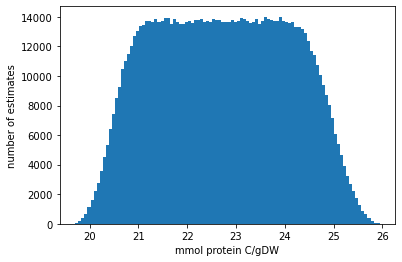

In [3]:
# Mass fraction of protein -- double check this range. 
protein_fraction_range = (0.45, 0.55)
# Number of carbons per amino acid
aa_nc_range = (4.9, 5.1)
# MW of a protein-bound amino acid
aa_mw_range = (108, 112)

n_samples = int(1e6)
protein_fracs = np.random.uniform(
        *protein_fraction_range, size=n_samples)
aa_ncs = np.random.uniform(
        *aa_nc_range, size=n_samples)
aa_mws = np.random.uniform(
        *aa_mw_range, size=n_samples)

molC_per_gDWs = aa_ncs*protein_fracs/aa_mws
mmolC_per_gDWs = 1e3*molC_per_gDWs

# histogram of the 1e6 estimates
plt.hist(mmolC_per_gDWs, bins=100)
plt.xlabel('mmol protein C/gDW')
plt.ylabel('number of estimates')
plt.show()

In [4]:
pctiles = [2.5, 25, 50, 75, 97.5]
pctile_vals = np.percentile(mmolC_per_gDWs, pctiles)
print('mmol protein C / gDW:')
print('median estimate: {0:.2f}'.format(pctile_vals[2]))

print('geometric mean: {0:.2f}'.format(gmean(mmolC_per_gDWs)))
print('95% CI: {0:.2f}-{1:.2f}'.format(pctile_vals[0], pctile_vals[-1]))
print('IQR: {0:.2f}-{1:.2f}'.format(pctile_vals[1], pctile_vals[-2]))

# For later use - present the IQR
mmol_protein_C_per_gDW_IQR = pctile_vals[[1,-2]].copy()
mmol_protein_C_per_gDW_median = pctile_vals[2]

mmol protein C / gDW:
median estimate: 22.73
geometric mean: 22.69
95% CI: 20.42-25.10
IQR: 21.59-23.86


In [5]:
d = pd.DataFrame(dict(percentile=pctiles, value=pctile_vals))
d.to_csv('../data/proteomes/Coli/mmol_protC_per_gDW_est.csv', index=False)

In [6]:
# Load up the chemostat data and do some unit conversions here. 
# Kayser et al has specific O2 consumption rates for E. coli in a chemostat
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth.csv').dropna(how='all')

# Postma et al has specific O2 consumption rates for Yeast in a chemostat
postma_chemostat_df = pd.read_csv('../data/chemostat_data/postma_chemostat_growth.csv').dropna(how='all')

In [15]:
mw_o2 = 31.999
mw_co2 = 44.01
mw_glucose = 180.156
NADH_per_O2 = 2
r_o2_mmol_g_h = 1e3*kayser_chemostat_df.r_o2_g_g_h/mw_o2
r_co2_mmol_g_h = 1e3*kayser_chemostat_df.r_co2_g_g_h/mw_co2
r_glucose_mmol_g_h = 1e3*kayser_chemostat_df.r_glucose_g_g_h/mw_glucose

kayser_chemostat_df['r_o2_mmol_g_h'] = r_o2_mmol_g_h
kayser_chemostat_df['r_o2_mmol_NADH_g_h'] = r_o2_mmol_g_h*NADH_per_O2
kayser_chemostat_df['r_co2_mmol_g_h'] = r_co2_mmol_g_h
kayser_chemostat_df['r_glucose_mmol_g_h'] = r_glucose_mmol_g_h

qO2_mmol_NADH_gDW_hr = postma_chemostat_df.qO2_mmol_gDW_hr*NADH_per_O2
postma_chemostat_df['qO2_mmol_NADH_gDW_hr'] = qO2_mmol_NADH_gDW_hr

In [16]:
kayser_chemostat_df.to_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv', index=False)
postma_chemostat_df.to_csv('../data/chemostat_data/postma_chemostat_growth_unit_conv.csv', index=False)

In [17]:
postma_chemostat_df

,D_per_h,qO2_mmol_gDW_hr,qCO2_mmol_gDW_hr,qO2_mmol_NADH_gDW_hr
0,0.050,1.10,1.51,2.20
1,0.100,2.43,2.84,4.86
2,0.150,3.76,4.21,7.52
3,0.200,5.10,5.57,10.20
4,0.250,6.37,6.87,12.74
5,0.275,6.48,7.48,12.96
6,0.300,7.18,8.21,14.36
7,0.325,9.08,9.55,18.16
8,0.340,9.75,10.37,19.50
9,0.360,9.74,10.18,19.48


In [18]:
kayser_chemostat_df

,D_per_h,biomass_g_l,glucose_g_l,acetate_g_l,ammonium_g_l,CTR,OTR,c_recovery_pct,n_recovery_pct,r_biomass_g_l_h,r_glucose_g_g_h,r_co2_g_g_h,r_o2_g_g_h,r_acetate_g_g_h,r_ammonium_g_g_h,r_o2_mmol_g_h,r_co2_mmol_g_h,r_o2_mmol_NADH_g_h,r_glucose_mmol_g_h
0,0.044,5.07,0.000,0.000,1.709,0.286,0.222,96,99,0.223,0.087,0.056,0.0437,0.0 000,0.0060,1.365668,1.272438,2.731335,0.482915
1,0.066,5.05,0.000,0.000,1.688,0.440,0.288,97,98,0.333,0.131,0.087,0.0570,0.0 000,0.0093,1.781306,1.976823,3.562611,0.727148
2,0.134,5.29,0.000,0.000,1.652,0.924,0.576,101,98,0.709,0.253,0.175,0.1089,0.0 000,0.0190,3.403231,3.976369,6.806463,1.404338
3,0.150,5.24,0.000,0.000,1.650,0.915,0.615,95,98,0.785,0.287,0.175,0.1175,0.0 000,0.0215,3.671990,3.976369,7.343979,1.593064
4,0.170,5.23,0.000,0.000,1.656,1.113,0.896,98,98,0.889,0.325,0.213,0.1713,0.0 000,0.0242,5.353292,4.839809,10.706585,1.803992
5,0.203,5.41,0.000,0.000,1.629,1.276,0.950,98,98,1.098,0.375,0.236,0.1757,0.0 000,0.0289,5.490797,5.362418,10.981593,2.081529
6,0.265,5.28,0.000,0.000,1.632,1.536,1.044,93,97,1.399,0.502,0.291,0.1978,0.0 000,0.0385,6.181443,6.612134,12.362886,2.786474
7,0.280,5.53,0.000,0.000,1.620,1.676,1.226,97,98,1.548,0.506,0.303,0.2216,0.0 000,0.0395,6.925216,6.884799,13.850433,2.808677
8,0.300,5.53,0.000,0.000,1.612,1.795,1.312,97,98,1.659,0.542,0.325,0.2372,0.0 000,0.0427,7.412732,7.384685,14.825463,3.008504
9,0.347,5.61,0.229,0.000,1.617,1.905,1.357,96,99,1.945,0.605,0.340,0.2421,0.0 000,0.0485,7.565861,7.725517,15.131723,3.358201


In [12]:
mask = np.logical_and(kayser_chemostat_df.D_per_h.notnull(), kayser_chemostat_df.r_o2_mmol_NADH_g_h.notnull())
masked_kayser = kayser_chemostat_df[mask]
kayser_reg = linregress(masked_kayser.D_per_h, masked_kayser.r_o2_mmol_NADH_g_h)
postma_reg = linregress(postma_chemostat_df.D_per_h, postma_chemostat_df.qO2_mmol_NADH_gDW_hr)

all_D = np.concatenate([masked_kayser.D_per_h.values, postma_chemostat_df.D_per_h.values])
all_resp_NADH_gDW_hr = np.concatenate([
    masked_kayser.r_o2_mmol_NADH_g_h.values, postma_chemostat_df.qO2_mmol_NADH_gDW_hr.values])
all_reg = linregress(all_D, all_resp_NADH_gDW_hr)

_l_get_dict = lambda r: dict(slope=r.slope, intercept=r.intercept,
                             R=r.rvalue, P=r.pvalue, slope_stderr=r.stderr,
                             int_stderr=r.intercept_stderr)
postma_reg_dict = _l_get_dict(postma_reg)
kayser_reg_dict = _l_get_dict(kayser_reg)
both_reg_dict = _l_get_dict(all_reg)

# Save the fits as a DF
pd.DataFrame(dict(postma_fit=postma_reg_dict,
                  kayser_fit=kayser_reg_dict,
                  both_fit=both_reg_dict)).to_csv(
    '../data/chemostat_data/respiratory_NADH_consumption_fits.csv')

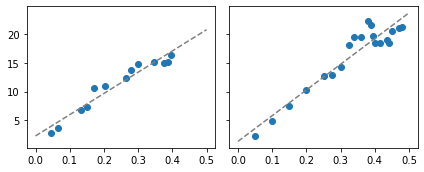

In [13]:
# plot the fits for a sanity check
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,2.5))
plt.sca(axs[0])
plt.scatter(masked_kayser.D_per_h, masked_kayser.r_o2_mmol_NADH_g_h)
xs = np.arange(0, 0.51, 0.1)
pred_ys = kayser_reg.slope*xs + kayser_reg.intercept
plt.plot(xs, pred_ys, ls='--', color='grey')

plt.sca(axs[1])
plt.scatter(postma_chemostat_df.D_per_h, postma_chemostat_df.qO2_mmol_NADH_gDW_hr)
pred_ys = postma_reg.slope*xs + postma_reg.intercept
plt.plot(xs, pred_ys, ls='--', color='grey')

plt.tight_layout()
plt.show()

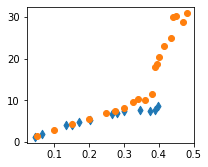

In [14]:
# CO2 production
fig, axs = plt.subplots(figsize=(3,2.5))
plt.scatter(masked_kayser.D_per_h, masked_kayser.r_co2_mmol_g_h, marker='d')
plt.scatter(postma_chemostat_df.D_per_h, postma_chemostat_df.qCO2_mmol_gDW_hr)
plt.show()